# Categorical Variables

In the last section we talked about scaling for continuous features, which all the features in the cancer dataset were.
In the lending club data, we also saw another type of feature, categorical or discrete features. Categorical or discrete features are those can take one of several distinct values that are usually not numerical, and often not even ordered. In the lending club data, examples were the grade, which could be a letter from 'A' to 'G', or home ownership, which could be 'RENT', 'MORTGAGE', 'OWN' or 'ANY'.


In [1]:
import pandas as pd

In [2]:
loans = pd.read_csv("C:/Users/t3kci/Downloads/loan.csv/loan.csv", nrows=100000)

C:\Users\t3kci\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.grade.unique()

array(['C', 'D', 'B', 'A', 'E', 'F', 'G'], dtype=object)

In [4]:
loans.home_ownership.unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

Most machine learning algorithms require that we preprocess these features into some numeric encoding before we can use them. For our old friend ``KNeighborsClassifier``, we could in theory define a distance metric on these categorical features (which is certainly possible and many options exist), though the simpler and more common approach is to transform the data so we can use the standard euclidean distance on all the features.
Let's take a small subset of the data to investigate the possible preprocessing methods:

In [5]:
# look only at the two loan statuses we discussed in Chapter TODO
loans_paid = loans[loans.loan_status.isin(['Fully Paid', 'Charged Off'])]
# For this example, we want some paid and some charged off loans
# we group them to make sure we get some of both. We then take the first 100 and remove the grouping index
some_loans = loans_paid.groupby('loan_status').apply(lambda x: x.head(10)).reset_index(drop=True)
# we only consider three relatively well-behaved features and the loan status
small_data = some_loans[['loan_amnt', 'home_ownership', 'grade', 'loan_status']]
small_data

,loan_amnt,home_ownership,grade,loan_status
0,8000,MORTGAGE,A,Charged Off
1,6000,MORTGAGE,C,Charged Off
2,10000,MORTGAGE,A,Charged Off
3,10000,RENT,E,Charged Off
4,35000,MORTGAGE,C,Charged Off
5,4800,MORTGAGE,C,Charged Off
6,35000,RENT,C,Charged Off
7,15000,OWN,B,Charged Off
8,16000,RENT,B,Charged Off
9,25000,MORTGAGE,A,Charged Off


The loan amount is a continuous feature; it's an integer amount, but grade and home ownership are categorical. The loan_status is our classification target (which means it's also a discrete variable, but we don't consider it a feature and won't process it as such).
Scikit-learn requires you to explicitly handle categorical features in most cases, which is unlike some other libraries and frameworks. However, that gives you more control over the processing, and a better idea of what happens to your data.

The encoding that is most appropriate depends on the model you're using, but there are some general encoding schemes that are frequently used.

## Ordinal encoding
One of the simplest ways to encode categorical data is to assign an integer to each category. You could do this with the ``OrdinalEncoder`` in scikit-learn, or with pandas by using pandas categorical data:

In [6]:
# extract a column and convert it to categorical data (it was represented as strings before)
home_ownership_cat = small_data.home_ownership.astype('category')
home_ownership_cat

0     MORTGAGE
1     MORTGAGE
2     MORTGAGE
3         RENT
4     MORTGAGE
5     MORTGAGE
6         RENT
7          OWN
8         RENT
9     MORTGAGE
10    MORTGAGE
11    MORTGAGE
12    MORTGAGE
13        RENT
14    MORTGAGE
15        RENT
16        RENT
17        RENT
18    MORTGAGE
19         OWN
Name: home_ownership, dtype: category
Categories (3, object): [MORTGAGE, OWN, RENT]

In [7]:
# get integer codes from the categorical data
# all categorical operations are accessible through the cat attribute:
home_ownership_cat.cat.codes

0     0
1     0
2     0
3     2
4     0
5     0
6     2
7     1
8     2
9     0
10    0
11    0
12    0
13    2
14    0
15    2
16    2
17    2
18    0
19    1
dtype: int8

We could create a new dataframe using these integer codes, which now could be interpreted by a machine learning model. However, this is often problematic as this imposes an order and a distance between the different categories, that might not accurately reflect the semantics of the data. Both pandas and scikit-learn by default use the lexical ordering of categories, so MORTGAGE corresponds to 0, OWN to 1 and RENT to 2. This order makes little sense. We could specify our own ordering, say RENT, MORTGAGE, OWN (describing degrees of ownership) but this is also not entirely satisfactory: if we encode it using integers, we postulate that the difference between RENT and MORTGAGE is the same as the difference between MORTGAGE and OWN, and the difference between RENT and OWN is twice the distance between MORTGAGE and OWN. Making these assumption seems somewhat questionable, and in many cases, even ordering the categories might be hard - imagine working on a dataset of cars that includes the color, imposing any ordering there seems very arbitray.

For the grades, using integer encodings might be reasonable, as there is a clear ordering and distance. Whether this is appropriate might depend on the model you are using. If there is very few categories, such as here, it's probably a safer bet to forego the ordinal encoding and use a different scheme instead.

## One-Hot Encoding

The most commonly used encoding scheme for categorical variables by far is the so-called one-hot encoding or dummy encoding. The idea behind one-hot encoding is to add a new column for each value of a categorical variable, and set the column to 1 for the category that applies to the row, and 0 for all the other categories. An easy way to compute this encoding is the ``get_dummies`` function in pandas:

In [8]:
small_data[['grade']].head()

,grade
0,A
1,C
2,A
3,E
4,C


In [9]:
pd.get_dummies(small_data[['grade']]).head()

,grade_A,grade_B,grade_C,grade_D,grade_E
0,1,0,0,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,1,0,0


As you can see, ``get_dummies`` replaced the one column ``grade`` by five columns, one for each possible value. The original value for the grade of first row was ``A`` so the new column ``grade_A`` has a 1, while all the other columns have a 0.
We can also call ``get_dummies`` on the whole dataframe. In this case, it will apply dummy encoding to all the columns that have either categorical data or objects (including strings):

In [10]:
pd.get_dummies(small_data).head()

,loan_amnt,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,loan_status_Charged Off,loan_status_Fully Paid
0,8000,1,0,0,1,0,0,0,0,1,0
1,6000,1,0,0,0,0,1,0,0,1,0
2,10000,1,0,0,1,0,0,0,0,1,0
3,10000,0,0,1,0,0,0,0,1,1,0
4,35000,1,0,0,0,0,1,0,0,1,0


As you can see, ``loan_amnt`` wasn't changed, while the dummy encoding was applied to all the other columns, including the target ``loan_status``. As we don't want to encode this column, we can explicitly provide the columns that we want to encode:

In [11]:
pd.get_dummies(small_data, columns=['home_ownership', 'grade']).head()

,loan_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E
0,8000,Charged Off,1,0,0,1,0,0,0,0
1,6000,Charged Off,1,0,0,0,0,1,0,0
2,10000,Charged Off,1,0,0,1,0,0,0,0
3,10000,Charged Off,0,0,1,0,0,0,0,1
4,35000,Charged Off,1,0,0,0,0,1,0,0


```{note}
If a categorical variable was already represented as an integer you can force pandas to apply dummy encoding by passing the column name to the ``columns`` parameter of ``pd.get_dummies``.
```

### Aligning dataframes with pandas
A common problem in using ``get_dummies`` is that if you have multiple datasets or files, and you call ``get_dummies`` on each of them, you might get inconsistent encodings.
Let's split our toy data into training and test set and apply ``get_dummies`` on them separately:

In [12]:
from sklearn.model_selection import train_test_split
small_train, small_test = train_test_split(small_data, random_state=21)
# To avoid setting with copy warnings we copy the data after splitting
# this is probably not necessary
small_train = small_train.copy()
small_test = small_test.copy()
pd.get_dummies(small_train, columns=['home_ownership', 'grade'])

,loan_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E
17,2500,Fully Paid,0,1,0,0,1,0,0
18,4000,Fully Paid,1,0,0,0,0,1,0
11,40000,Fully Paid,1,0,0,0,1,0,0
6,35000,Charged Off,0,1,0,0,1,0,0
14,8425,Fully Paid,1,0,0,0,0,0,1
1,6000,Charged Off,1,0,0,0,1,0,0
2,10000,Charged Off,1,0,1,0,0,0,0
12,20000,Fully Paid,1,0,1,0,0,0,0
3,10000,Charged Off,0,1,0,0,0,0,1
8,16000,Charged Off,0,1,0,1,0,0,0


In [13]:
pd.get_dummies(small_test, columns=['home_ownership', 'grade'])

,loan_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D
7,15000,Charged Off,0,1,0,0,1,0,0
10,30000,Fully Paid,1,0,0,0,0,0,1
19,2700,Fully Paid,0,1,0,1,0,0,0
13,4500,Fully Paid,0,0,1,0,1,0,0
5,4800,Charged Off,1,0,0,0,0,1,0


Both of the dataframes have seven columns, but the meaning of the columns is quite different. The training set doesn't have a column for ``home_ownership=OWN`` while the test set doesn't have a column for ``grade=E``.
However, remember that scikit-learn doesn't know about column names in dataframes, so if you'd passed this data directly into scikit-learn, you would get meaningless predictions without knowing it! TODO callout?

There's several ways to avoid this; the easiest is to use ``get_dummies`` before splitting the data, that might not be possible if new data arrives and you want to apply an existing model.
Another way is to encode all categorical variables using the pandas categorical type, and specifying all the known categories:

In [14]:
ownership_cats = ['MORTGAGE', 'OWN', 'RENT']
grade_cats = ['A', 'B', 'C', 'D', 'E']

small_test_explicit_cats = small_test.copy()
small_test_explicit_cats['home_ownership'] = pd.Categorical(small_test_explicit_cats['home_ownership'], categories=ownership_cats)
small_test_explicit_cats['grade'] = pd.Categorical(small_test_explicit_cats['grade'], categories=grade_cats)

Now the columns are aware of all possible values, and all of them will receive a column, whether the value is present or not (not the all-zero column `grade_E`):

In [15]:
pd.get_dummies(small_test_explicit_cats, columns=['home_ownership', 'grade'])

,loan_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E
7,15000,Charged Off,0,1,0,0,1,0,0,0
10,30000,Fully Paid,1,0,0,0,0,0,1,0
19,2700,Fully Paid,0,1,0,1,0,0,0,0
13,4500,Fully Paid,0,0,1,0,1,0,0,0
5,4800,Charged Off,1,0,0,0,0,1,0,0


This method is very explicit and safe, but can be a bit cumbersome if there's many categorical columns, or not all of the categories are known beforehand.
A somewhat simpler and less explicit method is using ``pd.align`` after calling ``get_dummies``:

In [16]:
# compute dummy encoding (the columns will not match afterwards)
small_train_dummies = pd.get_dummies(small_train, columns=['home_ownership', 'grade'])
small_test_dummies = pd.get_dummies(small_test, columns=['home_ownership', 'grade'])

# align dataframes
# join='right' aligns test (left=self) to train (right=other) keeping only the columns in train
# axis=1 means we align only the columns, and don't try joining the row indices
# align returns two aligned frames; because we did a right join, train is unchanged
# so we can discard the second return value (and assign it to _)
# fill value specifies what to put into previously non-existing columns
test_aligned, _ = small_test_dummies.align(small_train_dummies, join='right', axis=1, fill_value=0)
test_aligned

,loan_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E
7,15000,Charged Off,0,0,0,1,0,0,0
10,30000,Fully Paid,1,0,0,0,0,1,0
19,2700,Fully Paid,0,0,1,0,0,0,0
13,4500,Fully Paid,0,1,0,1,0,0,0
5,4800,Charged Off,1,0,0,0,1,0,0


The result is an aligned dataframe ``test_aligned`` that has the same columns as ``small_train_dummies``, the dataframe it was aligned with.
This ensures that the shapes are compatible between training and test set and we will get meaningful results from scikit-learn.
Note that 'OWN' column that was previously present in the test set was dropped as it is not present in the training set.
We could also perform an inner join when aligning the dataframes (which is the default in ``pd.align`` if you don't specify ``join``), so that the aligned dataframes contain all the columns present in either of the dataframes:


In [17]:
# if we don't specify join, an inner join is performed and we retain all the columns
# in this case we also want to store the new aligned training set
test_aligned, train_aligned = small_test_dummies.align(small_train_dummies, axis=1, fill_value=0)
test_aligned

,grade_A,grade_B,grade_C,grade_D,grade_E,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,loan_amnt,loan_status
7,0,1,0,0,0,0,1,0,15000,Charged Off
10,0,0,0,1,0,1,0,0,30000,Fully Paid
19,1,0,0,0,0,0,1,0,2700,Fully Paid
13,0,1,0,0,0,0,0,1,4500,Fully Paid
5,0,0,1,0,0,1,0,0,4800,Charged Off


However, that's not very useful if you already created a model using the original training dataset.

## One-hot with sklearn
Another option (and the one we will use for most of the book) is to do our encoding with scikit-learn. Because scikit-learn has a concept of training and test set, the issue of aligning the data is handled automatically.
The dummy or one-hot encoding in scikit-learn is implemented in the ``OneHotEncoder``, which is a transformer, just like other preprocessing methods.

In [18]:
from sklearn.preprocessing import OneHotEncoder
# By default, OneHotEncoder errors if it sees unknown categories in the test data
# we will overwrite this behavior by specifying handle_unknown='ignore'
# also OneHotEncoder by default outputs scipy sparse matrices, which are more efficient but cumbersome
# we disable that with sparse=False
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# fit on the training set; stores the categories for each column
ohe.fit(small_train)
# apply one-hot encoding to both training and test set
X_train_ohe = ohe.transform(small_train)
X_test_ohe = ohe.transform(small_test)

In [19]:
X_train_ohe

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0.,

```{margin} Feature names in scikit-learn
While scikit-learn doesn't output pandas dataframes (for now) we can get feature names for the output of some transformers using the ``get_feature_names`` method.
```

There are two things you might notice in this output: as with all scikit-learn transformations, the output is a numpy array without column names, which can be a bit inconvenient.
Secondly, all the columns have been one-hot-encoded, the loan amount is not present any more.
We can actually get the feature names by using the ``get_feature_names`` method of the ``OneHotEncoder``:

In [20]:
ohe.get_feature_names()

array(['x0_2500', 'x0_4000', 'x0_6000', 'x0_6600', 'x0_8000', 'x0_8425',
       'x0_10000', 'x0_16000', 'x0_20000', 'x0_25000', 'x0_35000',
       'x0_40000', 'x1_MORTGAGE', 'x1_RENT', 'x2_A', 'x2_B', 'x2_C',
       'x2_D', 'x2_E', 'x3_Charged Off', 'x3_Fully Paid'], dtype=object)

By default, the input columns in scikit-learn are named ``x0``, ``x1`` and so on, so what this tells us is that for the first feature, loan amount, several new columns were added to one-hot-encode the observed integer values, which was not what we had in mind. We can get more informative feature names by passing the original dataframe column names to ``get_feature_names``:

In [21]:
ohe.get_feature_names(small_train.columns)

array(['loan_amnt_2500', 'loan_amnt_4000', 'loan_amnt_6000',
       'loan_amnt_6600', 'loan_amnt_8000', 'loan_amnt_8425',
       'loan_amnt_10000', 'loan_amnt_16000', 'loan_amnt_20000',
       'loan_amnt_25000', 'loan_amnt_35000', 'loan_amnt_40000',
       'home_ownership_MORTGAGE', 'home_ownership_RENT', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'loan_status_Charged Off', 'loan_status_Fully Paid'], dtype=object)

OneHotEncoder, like all other estimators in scikit-learn, always works on all input columns. So we need to pass it only the column that we want to transform.
So one possible way to do this would be to slice of the categorical columns, transform them with ``OneHotEncoder``, like so:

In [22]:
small_train.columns

Index(['loan_amnt', 'home_ownership', 'grade', 'loan_status'], dtype='object')

In [23]:
train_cat = small_train[['home_ownership', 'grade']]
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_cat_ohe = ohe.fit_transform(train_cat)
train_cat_ohe

array([[0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 0.]])

We can now make this one-hot-encoded array back into a dataframe by using ``get_feature_names``:

In [24]:
train_df_ohe = pd.DataFrame(train_cat_ohe,
                            # create column names
                            columns=ohe.get_feature_names(train_cat.columns),
                            # keep the old index.
                            # this is optional but will make joining with the other features easier
                            index=train_cat.index)
train_df_ohe.head()

,home_ownership_MORTGAGE,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E
17,0.0,1.0,0.0,0.0,1.0,0.0,0.0
18,1.0,0.0,0.0,0.0,0.0,1.0,0.0
11,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0
14,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Then we can concatenate it again with the remaining 'amount' feature:

In [25]:
train_df_all = pd.concat([train_df_ohe, small_train[['loan_amnt']]], axis=1)
train_df_all.head()

,home_ownership_MORTGAGE,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,loan_amnt
17,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2500
18,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4000
11,1.0,0.0,0.0,0.0,1.0,0.0,0.0,40000
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,35000
14,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8425


While this is the result we wanted, this was pretty complicated compared to using ``pd.get_dummies``.
Luckily, scikit-learn has another tool that will make this much easier, the ``ColumnTransformer``.

## Selecting Columns in sklearn

The ``ColumnTransformer`` is another meta-estimator, similar to the ``Pipeline``, for combining multiple transformations.
In particular, the ``ColumnTransformer`` allows you to apply different transformations to different subsets of the columns.
It's the only part of scikit-learn that explicitly uses pandas column names, and is made specificly to ease the use of pandas dataframes
as input to scikit-learn models.

In contrast to ``Pipeline``, which basically applies several transformations in sequence, the ``ColumnTransformer`` applies several transformations in parallel,
each on a subset of columns, and then concatenates the results, similar to what we did manually above. This is illustrate in Figure TODO.

TODO new image

![:scale 100%](images/column_transformer_schematic.png)

As with the pipeline, there is a ``make_column_transformer`` helper function to easily create a new column transformer.
The function takes tuples, where each tuple consists of a transformation and the columns the transformation should be applied to.
So to apply the ``OneHotEncoder`` to only the ``home_ownership`` and ``grade`` columns, we could do:

In [26]:
from sklearn.compose import make_column_transformer
# a single transformation, OneHotEncoder, applied to two columns
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), ['home_ownership', 'grade']))
# now we can pass the full dataset, as the column transformer will do the subsetting for us:
ct.fit(small_train)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['home_ownership', 'grade'])])

The ``make_column_transformer`` has created ``ColumnTransformer`` object for us with a single transformer. It has also automatically generated a name for the transformer using the lower cased class name, `'onehotencoder'`.
We can now use the ``ColumnTransformer`` to transform our dataset:

In [27]:
ct.transform(small_train)

array([[0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 0.]])

Again, we can get the column names for the output using ``get_feature_names``:
TODO this doesn't take the columns?!

In [28]:
ct.get_feature_names()

['onehotencoder__x0_MORTGAGE',
 'onehotencoder__x0_RENT',
 'onehotencoder__x1_A',
 'onehotencoder__x1_B',
 'onehotencoder__x1_C',
 'onehotencoder__x1_D',
 'onehotencoder__x1_E']

As you can see, by default, the ``ColumnTransformer`` only keeps the columns that we mentioned.
If we want to keep the remaining columns, we can specify ``remainder='passthrough':

In [29]:
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              ['home_ownership', 'grade']),
                             remainder='passthrough'
                            )
ct.fit_transform(small_train)

array([[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2500, 'Fully Paid'],
       [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4000, 'Fully Paid'],
       [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 40000, 'Fully Paid'],
       [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 35000, 'Charged Off'],
       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8425, 'Fully Paid'],
       [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 6000, 'Charged Off'],
       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 10000, 'Charged Off'],
       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 20000, 'Fully Paid'],
       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 10000, 'Charged Off'],
       [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 16000, 'Charged Off'],
       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 8000, 'Charged Off'],
       [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 6600, 'Fully Paid'],
       [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 35000, 'Charged Off'],
       [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 20000, 'Fully Paid'],
       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 25000, 'Charged Off']],
      dtype=object)

Typically we would not want the target in our data within scikit-learn, though, so we might want do drop it before, or we might want to specify only to pass through the 'loan_amnt' column.
We can pass through only some columns by adding a new transformation in the ColumnTransformer, though instead of passing a scikit-learn transformer, we pass the string `'passthrough'`:

In [30]:
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              ['home_ownership', 'grade']),
                             ('passthrough', ['loan_amnt'])
                            )
# we set numpy printoptions to not use scientific notation for nicer output
# and suppress all but three decimal places
import numpy as np
np.set_printoptions(suppress=True, precision=3)
ct.fit_transform(small_train)

array([[    0.,     1.,     0.,     0.,     1.,     0.,     0.,  2500.],
       [    1.,     0.,     0.,     0.,     0.,     1.,     0.,  4000.],
       [    1.,     0.,     0.,     0.,     1.,     0.,     0., 40000.],
       [    0.,     1.,     0.,     0.,     1.,     0.,     0., 35000.],
       [    1.,     0.,     0.,     0.,     0.,     0.,     1.,  8425.],
       [    1.,     0.,     0.,     0.,     1.,     0.,     0.,  6000.],
       [    1.,     0.,     1.,     0.,     0.,     0.,     0., 10000.],
       [    1.,     0.,     1.,     0.,     0.,     0.,     0., 20000.],
       [    0.,     1.,     0.,     0.,     0.,     0.,     1., 10000.],
       [    0.,     1.,     0.,     1.,     0.,     0.,     0., 16000.],
       [    1.,     0.,     1.,     0.,     0.,     0.,     0.,  8000.],
       [    0.,     1.,     0.,     1.,     0.,     0.,     0.,  6600.],
       [    1.,     0.,     0.,     0.,     1.,     0.,     0., 35000.],
       [    0.,     1.,     0.,     0.,     0.,    

If instead, we want to scale the 'loan_amnt' column, we can pass ``StandardScaler`` instead of ``'passthrough'``:


In [31]:
from sklearn.preprocessing import StandardScaler
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              ['home_ownership', 'grade']),
                             (StandardScaler(), ['loan_amnt'])
                            )
ct.fit_transform(small_train)

array([[ 0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -1.173],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   , -1.047],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.984],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.563],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   , -0.674],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -0.879],
       [ 1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.542],
       [ 1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.3  ],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   , -0.542],
       [ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   , -0.037],
       [ 1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.71 ],
       [ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   , -0.828],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.563],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.

Now we can finally transform our test dataset without much work:

In [32]:
ct.transform(small_test)

array([[ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   , -0.121],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  1.142],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   , -1.156],
       [ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   , -1.005],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   , -0.98 ]])

Instead of using the ``make_column_transformer`` function, we can also directly use the ``ColumnTransformer`` class. As with the ``Pipeline``, this allows us to explicitly give names to the different transformers:

In [33]:
from sklearn.compose import ColumnTransformer
# this is equivalent to the the column transformer created above
# each transformation is a tuple (name, transformer, columns)
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False),
                         ['home_ownership', 'grade']),
                        ('scaler', StandardScaler(), ['loan_amnt'])])

In [34]:
# hidden for gluing
import sklearn
sklearn.set_config(display='diagram')
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              ['home_ownership', 'grade']),
                             (StandardScaler(), ['loan_amnt']))
from myst_nb import glue
glue('ct_diagram', ct)
ct

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['home_ownership', 'grade']),
                                ('standardscaler', StandardScaler(),
                                 ['loan_amnt'])])

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['home_ownership', 'grade']),
                                ('standardscaler', StandardScaler(),
                                 ['loan_amnt'])])

````{note} Diagram representations of estimators
Starting with version 0.23, scikit-learn has diagram representations for estimators when running in jupyter.
These can be enabled using ``sklearn.set_config``:

```python
import sklearn
sklearn.set_config(display='diagram')
```

```{glue:} ct_diagram
```

In particular for more complex workflows they can come in really handy. Clicking on any of the estimators in the diagram will provide you with more details.
````

## Combining ColumnTransformer and Pipeline

While ``ColumnTransformer`` by itself is already quite awesome, the real power comes from combining it with ``Pipeline`` to encapsulate the whole preprocessing and model training.
Let's apply ``KNeighborsClassifier`` to the small subset of the lending club data we have been looking at. This is more for illustrative purposes, as we're using a tiny subset, and KNeighborsClassifier is potentially not a good model for this dataset, but we will see this combination in many of our later examples.

Let's start from the beginning create a small dataset with 200 'Charged Off' and 200 'Fully Paid' loans.

In [35]:
loans = pd.read_csv("C:/Users/t3kci/Downloads/loan.csv/loan.csv", nrows=1000000, low_memory=False)
loans_paid = loans[loans.loan_status.isin(['Fully Paid', 'Charged Off'])]
some_loans = loans_paid.groupby('loan_status').apply(lambda x: x.head(200)).reset_index(drop=True)
X = some_loans[['loan_amnt', 'home_ownership', 'grade', 'loan_status']]
X.head()

,loan_amnt,home_ownership,grade,loan_status
0,8000,MORTGAGE,A,Charged Off
1,6000,MORTGAGE,C,Charged Off
2,10000,MORTGAGE,A,Charged Off
3,10000,RENT,E,Charged Off
4,35000,MORTGAGE,C,Charged Off


In [36]:
X.loan_status.value_counts()

Fully Paid     200
Charged Off    200
Name: loan_status, dtype: int64

First, we split off the target column as usual, and split the data into training and test set:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='loan_status'),
                                                    X.loan_status, random_state=23)

X_train.head()

,loan_amnt,home_ownership,grade
332,12000,MORTGAGE,E
61,7125,RENT,E
185,10500,OWN,D
75,15000,OWN,C
135,40000,OWN,A


Next, we assemble our ``ColumnTransformer`` as we did above, applying scaling to the ``loan_amnt`` and applying one-hot encoding to ``home_ownership`` and ``grade``:

In [38]:
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              ['home_ownership', 'grade']),
                             (StandardScaler(), ['loan_amnt']))
ct

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['home_ownership', 'grade']),
                                ('standardscaler', StandardScaler(),
                                 ['loan_amnt'])])

Now, we use this ``ColumnTransformer`` as a preprocessing step in a ``Pipeline`` with ``KNeighborsClassifier``:

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe = make_pipeline(ct, KNeighborsClassifier(n_neighbors=1))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['home_ownership', 'grade']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['loan_amnt'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

Now, everything we need to do is embedded in the ``pipe`` object, and we can just run ``fit`` on the training set and ``score`` on the test set:

In [40]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.59

The result here is not too overwhelming, but a bit better than chance (which would be 50%, given that we constructed a balanced dataset).
However, the overall code for building and evaluating the model was quite minimal, and leaves little opportunity for casual mistakes.

## Selecting columns by type
If there are many columns, such as in the full lending club data, it can sometimes be a challenge to determine the types and correct preprocessing for all of them.
Usually, it pays of to understand each individual column, and invest some time understanding the meaning of all the values, plotting them, and so on.
For example, for integer values it might not be obvious whether they should be one-hot-encoded or not. The annual salary amount in the lending club data is continuous, but the easiest way to actually be certain about that is to know what the data represents. We know salary, or really any amount of money, will be continuous. Luckily in this dataset all the categorical variable are represented as strings, and so it's relatively easy to understand what they mean.
But without additional information, if a column contains small integers, these could either correspond to a continuous quantity, or be an encoding for categories.

This somewhat tricky case aside, for some quick plotting or prototyping, it might sometimes be enough to look at just the dtype of the columns.
Let's look again at the dtypes of the full lending club data:

In [41]:
loans.dtypes.value_counts()

float64    70
int64      39
object     36
dtype: int64

We could select only column of a certain type by using boolean masks:

In [42]:
# only select 'object' dtype columns, which are usually strings
loans.loc[:, loans.dtypes == 'object'].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
0,36 months,C,C1,Chef,10+ years,RENT,Not Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
1,60 months,D,D2,Postmaster,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2,36 months,D,D1,Administrative,6 years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
3,36 months,D,D2,IT Supervisor,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
4,60 months,C,C4,Mechanic,10+ years,MORTGAGE,Not Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


In [43]:
loans.loc[:, loans.dtypes == 'float64'].columns

Index(['id', 'member_id', 'funded_amnt_inv', 'int_rate', 'installment',
       'annual_inc', 'url', 'dti', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'revol_bal_joint', 'sec_app_inq_last_6

Some of these are categorical, some of these are dates (which we might choose to drop or parse as dates), but some of these might even have continuous aspects, such as the employment length:

In [44]:
loans.emp_length.value_counts()

10+ years    333964
2 years       90476
< 1 year      81758
3 years       81013
1 year        66927
5 years       61623
4 years       61101
6 years       43380
8 years       38349
7 years       34708
9 years       32224
Name: emp_length, dtype: int64

If you feel that dtypes are a good way to select features on your dataset, you can do so in ``ColumnTransformers`` even more easily with ``make_column_selector``:

In [45]:
from sklearn.compose import make_column_selector
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False),
                              # pass object dtype columns to OneHotEncoder
                             make_column_selector(dtype_include='object')),
                             # pass float and int dtypes to StandardScaler
                             (StandardScaler(), make_column_selector(dtype_include=['float', 'int'])))

In [46]:
# we're only using some of the columns as the whole dataset is quite messy
X = some_loans[['loan_amnt', 'int_rate', 'home_ownership', 'open_acc', 'grade']]
X.dtypes

loan_amnt           int64
int_rate          float64
home_ownership     object
open_acc            int64
grade              object
dtype: object

In [47]:
ct.fit(X)
# we can look at the fitted transformers to see which columns where passed where
ct.transformers_

[('onehotencoder',
  OneHotEncoder(handle_unknown='ignore', sparse=False),
  ['home_ownership', 'grade']),
 ('standardscaler', StandardScaler(), ['int_rate']),
 ('remainder', 'drop', [0, 3])]

The benefit of using ``make_column_selector`` instead of passing a boolean mask is that the correct columns are determined when fitting the ``ColumnTransformer`` which avoids mistakes when creating the mask.
The ``make_column_selector`` function can also match column names or exclude certain dtypes.

## Collinearity & Redundancy
```{sidebar} One-hot vs dummy naming
In some communities, one-hot encoding refers to using one column per category, while dummy encoding refers to leaving out one of them. Using this nomenclature, ``pd.get_dummies`` does one-hot encoding by default.
In pandas and scikit-learn the terms are used interchangeably and we're using them interchangeably in this book. TODO is this a good idea?
```
Coming back to one-hot encoding, there's one more important thing to know, which is that one-hot encoding is redundant. We can drop one of the columns for each categorical variable and still retain all the information: if all of the other columns are zero, the dropped one was 1, and if one of them is 1, the dropped one was 0. In other words, you could re-compute a column as one minus the sum of the other columns. Such a relationship is known as collinearity (or linear dependency). For some statistical models, the presence of such a relationship between the features can lead to numerical and statistical issues. Therefore, it is common in statistics to drop one of the columns. You can do that in pandas by using ``pd.get_dummies(X, drop_first=True)`` which will drop the first category for each feature:

In [48]:
pd.get_dummies(X).head()

,loan_amnt,int_rate,open_acc,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,8000,6.46,12,0,1,0,0,1,0,0,0,0,0,0
1,6000,14.47,8,0,1,0,0,0,0,1,0,0,0,0
2,10000,8.81,7,0,1,0,0,1,0,0,0,0,0,0
3,10000,27.27,4,0,0,0,1,0,0,0,0,1,0,0
4,35000,16.14,22,0,1,0,0,0,0,1,0,0,0,0


In [49]:
pd.get_dummies(X, drop_first=True).head()

,loan_amnt,int_rate,open_acc,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,8000,6.46,12,1,0,0,0,0,0,0,0,0
1,6000,14.47,8,1,0,0,0,1,0,0,0,0
2,10000,8.81,7,1,0,0,0,0,0,0,0,0
3,10000,27.27,4,0,0,1,0,0,0,1,0,0
4,35000,16.14,22,1,0,0,0,1,0,0,0,0


In ``OneHotEncoder``, you can specify ``drop='first'`` if you want to drop the first category, or you can specify the category you want to drop for each of the features.
The only model in scikit-learn for which retaining all of the feature is an issue is ``LinearRegression`` (which we'll discuss in Chapter TODO), but otherwise you don't have to worry about it. For many of the model in sklearn that we'll see in Chapter TODO, it can matter which feature you drop, and it might be harder to interpret the model once you do. Therefore I usually recommend keeping all features in one-hot-encoding, even though the representation is redundant.

### Dropping redundant binary features
There is one exception though, which is binary features. If you have a binary categorical feature, i.e. a feature with two categories, it is obviously redundant to encode it using OneHotEncoder. Let's look at the 'term' variable which has two values, '36 months' and '60 months':

In [50]:
loans['term'].value_counts()

 36 months    715939
 60 months    284061
Name: term, dtype: int64

If we encode this feature using OneHotEncoder, we will get two new features, one corresponding to the 36s month term, and the other to the 50 months term:

In [51]:
ohe = OneHotEncoder().fit(loans[['term', 'grade']])
# get feature names, passing in the original feature names
ohe.get_feature_names(['term', 'grade'])

array(['term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
      dtype=object)

However, these two features encode exactly the same information, in that the 36 months term feature is just 1 minus the 60 month term feature. This redundancy is not useful and will make any model less easy to interpret, and we can drop it using ``drop='if_binary'``:

In [52]:
ohe = OneHotEncoder(drop='if_binary').fit(loans[['term', 'grade']])
ohe.get_feature_names(['term', 'grade'])

array(['term_ 60 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'grade_G'], dtype=object)

Now there's only one feature to represent this information, while the 'grade' feature with seven categories has retained all columns.

## Impact Encoding & Dealing with many categories
Dealing with categorical features with many categories can be a bit tricky, as directly applying one-hot encoding is often not effective.
Let's look at the ``emp_title`` feature from the lending club data, which provides a job description of the borrower:

In [53]:
loans_paid.shape

(383181, 145)

In [54]:
title_counts = loans_paid.emp_title.value_counts()
title_counts

Teacher                                 6819
Manager                                 6609
Owner                                   3977
Driver                                  2982
Registered Nurse                        2859
                                        ... 
Corporate Delivery Specialist              1
telecom                                    1
Sewer Manitenance supervisor 1             1
Regulatory Compliance Survey Manager       1
Lead payroll admin                         1
Name: emp_title, Length: 108751, dtype: int64

We loaded 1,000,000 rows of data, and it contains 224,610 different employment titles. Several of the titles are very common, such as Teacher and Manager, while some of the titles appear only once, like 'Court Evaluator'. TODO numbers
Let's see how many of the value appear only once:

In [55]:
title_once = title_counts == 1
title_once.sum()

85905

That's most of them! Clearly it will be hard to learn from a category for which we have only seen one example. This is likely another example of a power-law distribution: most of the job titles appear only once, there are some that appear several times, but then there are some that appear much more frequently than all the rest, such as Teacher and Manager. We can validate this by looking at the counts of the counts:

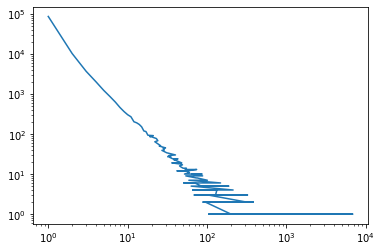

In [56]:
# a power-law distribution looks like a straight line in a log-log plot. This seems to hold reasonably well here.
title_counts.value_counts().plot(logy=True, logx=True)

Using a one-hot encoding on 224,610 categories will produce a feature space that will likely make learning hard. Even if we restrict ourselves to the categories that appear at least twice, we would still have over 50,000 features.
One option is to define a cut-off, and only look at the top k, say top 50 or top 100, most common values, and move everything else into an "other" category. Let's have a look at what the common values are:

Text(0.5, 1.0, '50 most common job titles')

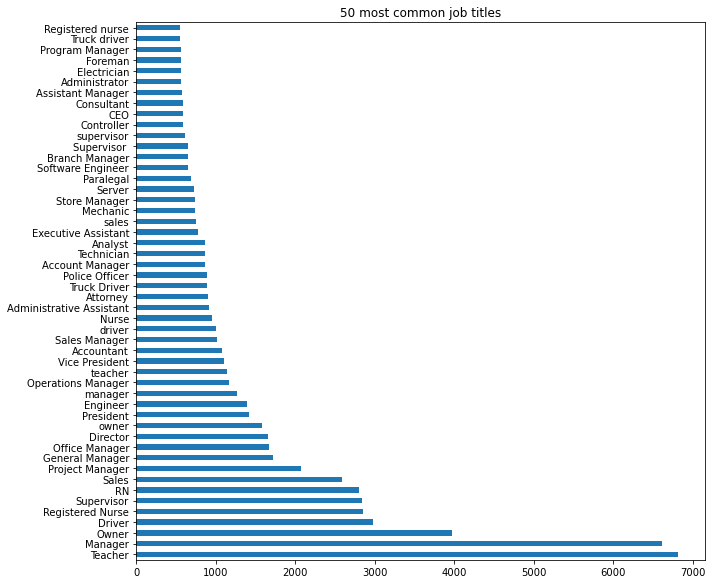

In [57]:
import matplotlib.pyplot as plt
title_counts[:50].plot(kind='barh', figsize=(10, 8))
plt.tight_layout()
plt.title("50 most common job titles")

Before we start encoding the feature, we might want to look at whether these are informative at all. We can for example look at how frequently each is associated with a fully paid loan.

In [58]:
# look at only the loans associated with a common job title
loans_50_jobs = loans_paid[loans_paid.emp_title.isin(title_counts[:50].index)]
loans_50_jobs.shape

(70672, 145)

In [59]:
# ensure our subsetting did what we wanted it to:
loans_50_jobs.emp_title.unique()

array(['Supervisor ', 'Teacher', 'Manager', 'Police Officer',
       'Truck Driver', 'Project Manager', 'Driver', 'supervisor',
       'Registered Nurse', 'Operations Manager', 'Vice President',
       'Program Manager', 'Executive Assistant', 'Sales', 'Supervisor',
       'RN', 'Sales Manager', 'Software Engineer', 'Controller',
       'Assistant Manager', 'Account Manager', 'manager',
       'General Manager', 'President', 'Paralegal', 'Administrator',
       'Director', 'Branch Manager', 'Mechanic', 'Technician',
       'Accountant', 'Owner', 'Analyst', 'driver', 'teacher', 'Engineer',
       'Store Manager', 'owner', 'Nurse', 'Administrative Assistant',
       'Office Manager', 'Attorney', 'Server', 'sales', 'Foreman',
       'Truck driver', 'Consultant', 'Electrician', 'Registered nurse',
       'CEO'], dtype=object)

In [60]:
# group by the employment title and take the loan status column
loan_status_by_title = loans_50_jobs.groupby('emp_title').loan_status
# some panda kung-fu: for each title, compute rations of fully paid and charged off, take only fully paid ones
paid_fraction = loan_status_by_title.value_counts(normalize=True).unstack('loan_status')['Fully Paid']
# TODO seaborn will make this better!

Text(0.5, 0, 'Fraction fully paid')

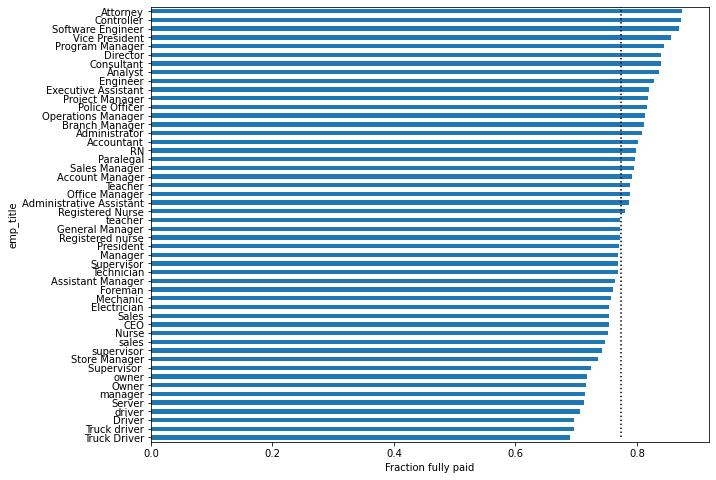

In [61]:
paid_fraction.sort_values().plot(kind='barh', figsize=(10, 8))
overall_payment_ratio = loans_50_jobs.loan_status.value_counts(normalize=True)['Fully Paid']
plt.vlines(overall_payment_ratio, 0, 50, linestyle=':')
plt.xlabel("Fraction fully paid")

This plot shows that there seems to be some information in the employment title. You might also note that some of the titles have capitalized an uncapitalized variants. In principle, the spelling difference could contain additional information. However, at least when looking directly at the outcomes, the different capitalization variants largely have the same outcomes (we could do a more rigorous statistical analysis for this if we were interested). Consolidating the capitalization could be done simply by lowercasing everything:

In [62]:
loans_paid['emp_title_lower'] = loans_paid['emp_title'].str.lower()

C:\Users\t3kci\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


If you explore the dataset more, you'll find that there are also misspellings, which are a bit harder to correct and which we'll leave for now.
After we consolidated the capitalization we can replace all but the 50 most common titles by "other":

In [63]:
title_counts_lower = loans_paid.emp_title_lower.value_counts()
common_titles = title_counts_lower.index[:50]
loans_paid['emp_title_50'] = loans_paid['emp_title_lower'].map(lambda x: x if x in common_titles else 'other')
loans_paid['emp_title_50'].value_counts()

C:\Users\t3kci\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


other                       297838
manager                       8162
teacher                       8071
owner                         5769
driver                        4104
registered nurse              3850
supervisor                    3569
sales                         3486
rn                            3169
project manager               2444
general manager               2268
office manager                2265
truck driver                  2037
director                      1788
president                     1682
engineer                      1630
sales manager                 1542
operations manager            1388
police officer                1319
nurse                         1268
accountant                    1229
vice president                1220
store manager                 1215
technician                    1153
mechanic                      1108
account manager               1051
administrative assistant      1040
attorney                       984
analyst             

Now, we have a relatively clean categorical variable, with only 51 values, which we can easily one-hot encode. TODO better transition

### Impact encoding
There is one more encoding scheme for categorical data that is commonly used and that recently has increased in popularity, known as impact encoding or target encoding.
This method of encoding categorical variables uses information about the classification target and is particularly useful for categorical features with many categories.

The idea behind impact encoding is to replace the categorical feature by the average outcome of the respective category.
In our case of employment title, the feature would become something like "likelihood of fully paying based on job title alone", i.e. the value for the job title in Figure TODO. In other words, if we want to encode a value of, say, 'ceo', we look at the average frequency of of loans with 'emp_title' ceo to be fully paid:

In [64]:
# should we recompute with lower-cased here? Or get rid of lower-casing?
paid_fraction['CEO']

0.7534013605442177

So any time we would an 'emp_title' of 'CEO' our new feature (which will take the place of 'emp_title') will be 0.75...

In principle we could compute this new feature using pandas alone by first computing the paid fraction (redoing it for all titles, not just the top 50, and taking lower-casing into account):

In [65]:
# Fill in emp_title_lower with "missing" where it's missing (otherwise these will be ignored)
# inplace means we're overwriting the existing column
loans_paid.emp_title_lower.fillna('missing', inplace=True)
# redoing the pandas trickery from above
paid_fraction_full = loans_paid.groupby('emp_title_lower').loan_status.value_counts(normalize=True).unstack('loan_status')['Fully Paid']
# NaN means none were paid
paid_fraction_full.fillna(0, inplace=True)

C:\Users\t3kci\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


And then adding the new feature based on ``emp_title`` to each row:

In [66]:
paid_fraction_full

emp_title_lower
 \toffice manager/medical assistant         0.0
 \tsecurity guard                           1.0
  ag                                        1.0
  assembler                                 0.0
  diversion investigator                    1.0
                                           ... 
zoo keeper                                  0.0
zoo lab coordinator                         0.0
zookeeper                                   1.0
zpic coordinator                            1.0
| principal business solution architect|    1.0
Name: Fully Paid, Length: 92041, dtype: float64

In [67]:
paid_fraction_full[loans_paid.emp_title_lower]

emp_title_lower
supervisor                              0.722992
assistant to the treasurer (payroll)    1.000000
teacher                                 0.784661
accounts examiner iii                   1.000000
senior director risk management         1.000000
                                          ...   
systems engineer                        0.843284
accounting                              0.782178
account rep                             0.833333
lpn                                     0.715953
equipment maint supervisor              1.000000
Name: Fully Paid, Length: 383181, dtype: float64

In [68]:
loans_paid.emp_title_lower

100                                supervisor 
152       assistant to the treasurer (payroll)
170                                    teacher
186                      accounts examiner iii
215            senior director risk management
                          ...                 
999995                        systems engineer
999996                              accounting
999997                             account rep
999998                                     lpn
999999              equipment maint supervisor
Name: emp_title_lower, Length: 383181, dtype: object

In [69]:
paid_fraction_full

emp_title_lower
 \toffice manager/medical assistant         0.0
 \tsecurity guard                           1.0
  ag                                        1.0
  assembler                                 0.0
  diversion investigator                    1.0
                                           ... 
zoo keeper                                  0.0
zoo lab coordinator                         0.0
zookeeper                                   1.0
zpic coordinator                            1.0
| principal business solution architect|    1.0
Name: Fully Paid, Length: 92041, dtype: float64

In [70]:
# we use join to map 'emp_title_lower' to the faction using the content of paid_fraction_full
loans_paid_new = loans_paid.join(paid_fraction_full, 'emp_title_lower')
# show the result; the new column is somewhat confusingly called 'Fully Paid' and we should probably rename it
loans_paid_new[['emp_title_lower', 'Fully Paid', 'loan_status']].head(10)

,emp_title_lower,Fully Paid,loan_status
100,supervisor,0.722992,Fully Paid
152,assistant to the treasurer (payroll),1.000000,Fully Paid
170,teacher,0.784661,Fully Paid
186,accounts examiner iii,1.000000,Fully Paid
215,senior director risk management,1.000000,Fully Paid
269,front office lead,0.600000,Fully Paid
271,sewell collision center,1.000000,Fully Paid
296,manager,0.759863,Fully Paid
369,service advisor,0.735294,Fully Paid
379,stylist,0.738739,Fully Paid


However, there's two caveats to this (relatively) simple approach: for a classification task like this, it might be beneficial to encode using the *log-odds* of the target (which is a simple non-linear transformation) instead of using the frequency (it will become clear why in Chapter TODO). Also, if a category appears only rarely, of just once, then the feature will be deceptively informative. If there is just one sample, the feature will encode just the target of this row. This is a typical case of information leakage. The resulting model is likely to learn that this column is particularly useful, though this knowledge will not translate to unseen data.
```{margin}
You can install the category_encoders package by running ``pip install category_encoders`` on the command line.
```
There are a couple of work-arounds for this, that we won't discuss in detail here, that either use additional hold-out sets or smoothing. Many of them are implemented in the ``category_encoders`` package, from which I'll particulary recomment the TargetEncoder (which implements todo) and GLMMEncoder (which implements TODO), which was shown to work well in practice todo reference masters thesis.
The ``category_encoder`` package broadly follows the API of scikit-learn, but also allows you to specify which columns the encoding should be applied to. So you can either use this feature, or the ColumnTransformer.

In [78]:
# TargetEncoder implements a smoothing variant from 
from category_encoders import TargetEncoder
te = TargetEncoder().fit(loans_paid[['emp_title_lower']], loans_paid.loan_status == 'Fully Paid')
te.transform(loans_paid[['emp_title_lower']].head(10))

,emp_title_lower
100,0.722992
152,0.775412
170,0.784661
186,0.939599
215,0.775412
269,0.603155
271,0.775412
296,0.759863
369,0.735294
379,0.738739


You can see that for categories with many samples, such as supervisor and teacher, the feature is identical to what we computed above, whereas for those with less features, such as 'sewell collision center', the estimate is much lower.

```{margin} TODO
maybe do a classification example with this?
```

## Summary
Categorical variables are quite common in many different settings, and while some models might be able to deal with them natively, preprocessing is necessary for most machine learning models. Using one-hot-encoding is the most common method and usually a good place to start. If there are many categories, it might be useful to encode only the most common ones, and combine all the infrequent ones.
Another common approach to dealing with categorical variables with many categories is target encoding, which is implemented in several variants in the ``category_encoders`` package.